# Two-stage object detection

现在我们开始了解一些目标检测模型或者是目标检测方法、算法。

我们之前提到过目标检测不同于图像分类，图像分类的方法基本上就是我们熟知的分类问题一种，但是对于目标检测算法，我们是有one-stage和two-stage之分的，所以我们了解这些方法的不同之处和共同之处。

## 一.RCNN模型

RCNN模型于CVPR2014中，由ROSS Girshick提出。

RCNN可谓是目标检测算法的基础中的基础，后面的算法不管是one-stage还是two-stage都是由其衍生而来。

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from PIL import Image

### 1.overfeat模型

我们还是回到如何设计一个网络的问题上来：

对于图像定位，很简单，一个输入图片tenor，一个输出类别+位置信息tensor。

对于目标检测呢？输入一个图片tensor，输出呢？我是不确定的(上方已经解释了)。

因此，可见迁移“classifier+regression”的方法到目标检测是会因为输出的不确定性而不可行。

overfeat模型就是用于解决此问题的，其中心思想运用到了sliding window(滑动窗口)的思想:

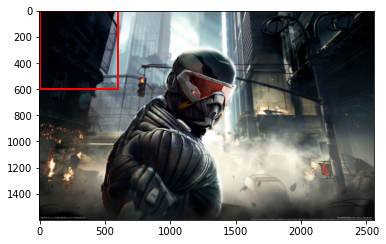

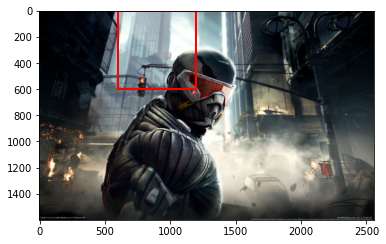

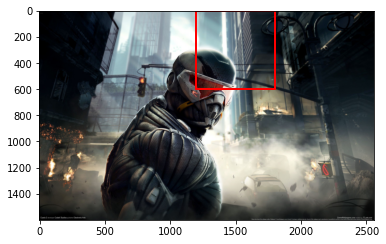

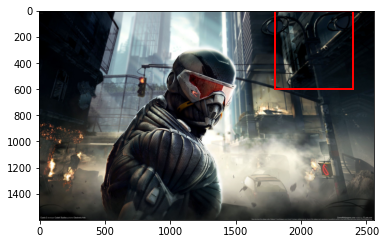

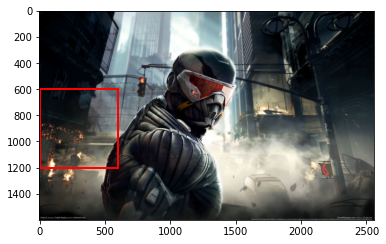

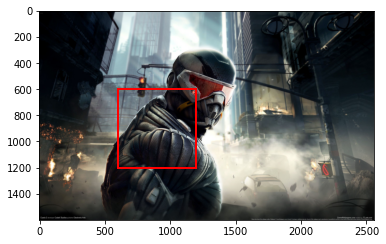

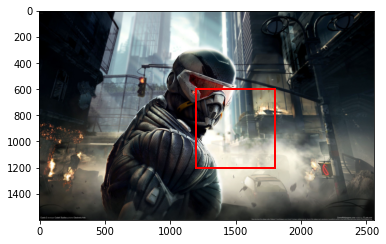

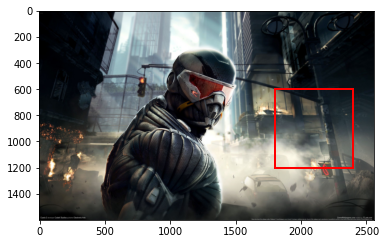

In [2]:
# 确定滑动窗口并将其初始化
xmin=0
ymin=0
xmax=600
ymax=600
slide_bbox=(xmin,ymin,xmax,ymax)
# 导入需要滑动的图片
ims=[]
image=plt.imread('../img/img1.jpg')
h=image.shape[0]
w=image.shape[1]
while ymax<=h:
    xmin=0
    xmax=600
    while xmax<=w:  
        fig=plt.figure()
        axis=fig.gca()  
        rec=plt.Rectangle(
            (xmin,ymin),
            xmax-xmin,ymax-ymin,
            linewidth=2,
            edgecolor='r',facecolor='none'
        )
        axis.add_patch(rec)
        im=axis.imshow(image)
        ims.append(im)
        plt.draw()
        plt.pause(0.01)
        xmax+=600
        xmin+=600
    ymin+=600
    ymax+=600

是不是很像卷积操作？假如检测框进行了m次向下滑动，每次n次向右滑动，那么有m*n个区域等待我们去检测。

换句话说，我们就把一张大图片分成了m*n个小图片，**并且假设每一个框框里面只有一个物体**。来进行检测。

注意哦，假设每一个框框只有一个物体，是不是相当于多个图像定位啦，我就可以在每一张小图片中做图像定位(classification+regression)就行了。

换句话说，目标检测就是多个目标定位组成的，理解上我们也是这样想的，运用的就是算法设计与分析上的“分而治之”的思想——把大图片的分类问题划分为每一张子图片的输出类别以及位置问题。

----

Tips:

如果提前了解过yolo系列的小伙伴就知道，为了适应不同大小物体，我们需要设计k种检测框，每种检测框会产生m个小图片。每种检测框大小不同，可以适应不同物体。

----

总结一下overfeat模型解决多目标检测问题的思路：
- 首先，制作k种检测框
- 其次，对每一张图像滑动分割，得到m张小图片
- 再者，将小图片进行classify和regress，得到预测值输出(class,xmin,ymin,xmax,ymax)
- 最后，将每一部分进行汇总，返回到原始输入图片x上，完成多个物体验证。

![图 3](../images/overfeat.jpg)

总结一下，overfeat模型优点在于提出了创新的解决多物体目标检测的思路，但是确定也很明显，通过上方的代码演示都可以看出来，overfeat模型非常耗时间、计算力，所以后续的研究也在解决这个问题。

### 2.RCNN的流程介绍

RCNN相较于overfeat的明智之处在于其没有使用暴力枚举的方法，而是采用**候选区域(region proposal method)**，是第一个基于神经网络的目标检测模型。

![图-RCNN](../images/RCNN.jpg)

步骤:
- 从原始图片找到可能存在目标的候选区域
- 然后制作为k个检测框
- 用每个检测框对图片进行m次分割
- 进入CNN进行分类+回归得到类别和位置信息

我们用Alexnet举例子：

- 用相关算法找出可能存在的候选区域，得出n个候选区域
- resize图片大小，进行CNN特征提取得到n个的特征向量
- 使用m个SVM进行分类，得到n*m的得分矩阵
- 进行NMS(非极大值抑制)，提出候选框
- 修正bbox，对bbox进行回归微调

### 3.RCNN步骤流程详解

#### (1)候选区域

我们输入一张图片，根据RCNN算法原理，需要对这张图片进行**候选区域**操作，比如说：输入一张图片，我得到了2000张小图片，这些“小图片”就是通过候选框选择算法得出的。

候选区域干了一件什么事情呢？输入一张图片，通过一些算法输出多个候选框。这些算法就是将一些图像中有相同特征(eg:纹理、颜色等)的部位进行组合，按照要求输出的检测框个数组合这些部位。

这些算法中比较有代表性的就是**选择性搜索(Selective Search)**：

- 选择性搜索算法需要先使用《Efficient Graph-Based Image Segmentation》论文里的方法产生初始的分割区域，然后使用相似度计算方法合并一些小的区域。
  
  ![](../images/origin.jpg)
  
  <img src=../images/segment.jpg width=300 height=230>


总结一下候选区域干的事情：
- 输入一张图片，得到候选区域框
- 并对候选区域进行resize操作


#### (2)特征提取以及SVM分类器

在得到了要输入网络的候选区域图片后，我们可以开始使用CNN对图片进行特征提取了。我们还是利用alexnet举例子，2000个3维张量在前向传播后会得到一个(2000,4096)的特征矩阵。然后，我们会将这些特征矩阵存入磁盘。这个好理解，就是为了方便我们后续的读取，我们真正要进行分类的就是这些特征矩阵。

至于SVM，是一个二分类分类器，它可以输入一个特征矩阵，输出一个概率矩阵。那么对于n分类问题，我们就需要准备n个SVM分类器，每个分类器分别判断每一个类别，输出给定特征属于该类别的概率。那么我们这里假如有20个类别，需要20个SVM，输入(2000,4096)，输出(2000,20)的分类矩阵，每一个候选框就相当于了有了20个概率值。

总结一下这一步：
- 输入图片tensor到CNN，输出特征矩阵
- 输入特征矩阵到SVM，输出类别矩阵。

#### (3)非极大值抑制(NMS)

我们从SVM拿到了相当于每个候选框的“得分”，判断是否正确圈定物体的得分。

但是，假如我们生成的候选框比较多，我们如何进行“剔除”从而得到最合适的候选框呢？这一步就需要用到非极大值抑制——**迭代剔除重合度较高的候选框**。

该算法的步骤原理就是，先设定一个阈值value，对于每一个SVM输出的类别得分向量(2000,)：

- 对于这2000个候选框，首先得到得分最高记为score_max
- 然后计算其与其他候选框的交并比iou_i，如果iou_i>value，则剔除该候选框，将score_max候选框加入到保留list中

循环这个过程，直到保存候选框的序列长度为0为止。

这个过程的目的就是为了分类选择最优的候选框。

#### (4)边界框回归

经过NMS后，我们得到了较优的候选框。但是这个时候的候选框也不一定是符号我们的label的，所以还是要进行regression过程。

假设我们得到的为(x,y,w,h)，而真实的标签label为(tx,ty,tw,th)**(ground truth)**，回归过程就需要寻找到一种变换：
$$
f((x,y,w,h))=(tx',ty',tw',th')
$$
并去学习完成这个变换的参数，从而使得:
$$
(tx',ty',tw',th')\approx (tx,ty,tw,th)
$$
这里用集合:
$$
\Theta
$$
表示。

这里的标签bbox用G表示，预测bbox用G'表示，未经过变换的用A'表示。

### 4.RCNN的训练过程

在训练之前，RCNN提出了正负样本的分类，所谓的正负样本，实践上就是相对而言较好和较坏的两类样本。

正样本是和图像上所有的y_train的bbox的重叠面积最大的IoU>=0.5的先验框;负样本则反之。

#### (1)预训练

所谓预训练，就是在开始训练我们的主干特征提取网络之前，通过载入已经一些网络参数(或者叫权重文件)来初始化一部分训练参数。

因为如果我们都知道网络训练调参需要一定的时间，我们RCNN以及后续的一些目标检测算法的训练网络所需要训练的参数十分多，光是考简单的初始化参数是不行，非常耗时间并且效果也不好。

#### (2)微调

输入我们的正负样本到预训练得到的model1，微调(实质上就是迁移学习)操作得到的模型就记作model2.

#### (3)SVM分类器训练

针对于每一个类别训练一个SVM分类器。

当然了，这个过程中要注意适当调配有object和无object两种训练样本的比例。

#### (4)bounding box回归器训练

只对与label_bbox重合度较高的pred_proposal_bbox进行回归，其余的则不参加回归训练。

### 5.RCNN的优缺点总结

#### (1)优点：
- 开创了two-stage的CNN目标检测网络
- 在VOC2007数据集上的平均精确度达到了66%

#### (2)缺点：
- 训练过程不能够一步到位，非常麻烦，步骤繁琐。
- 训练耗时、速度慢。
- 先验框图像变形问题不能够彻底解决。